In [1]:
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='Malgun Gothic',
              rc=custom_params)

In [3]:
print( f'# pandas:       {pd.__version__}' )
print( f'# numpy:        {np.__version__}' )
print( f'# matplotlib:   {mpl.__version__}' )
print( f'# seaborn:      {sns.__version__}' )
print( f'# statsmodels:  {sm.__version__}' )
print( f'# scikit-learn: {sklearn.__version__}' )
print( f'# pmdarima:     {pm.__version__}' )

# pandas:       2.0.3
# numpy:        1.25.2
# matplotlib:   3.7.2
# seaborn:      0.12.2
# statsmodels:  0.14.0
# scikit-learn: 1.3.0
# pmdarima:     2.0.3


In [4]:
df_raws = pd.read_csv("raws.csv")
df_op_ts = df_raws.set_index('target_dates').sort_index()
df_op_ts.head()

,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,op_rate_1d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
target_dates,,,,,,,,,,,,,,,,,,,,,
2019-09-08,0.381038,0.134719,0.095673,0.081302,0.073248,0.067846,0.059269,0.050881,0.392379,0.130225,...,3850,1190,0,18.8,24.4,9,2019,36,6,True
2019-09-09,0.294693,0.094521,0.058669,0.049279,0.040270,0.033519,0.029069,0.024346,0.316189,0.095190,...,2392,1777,0,90.4,24.7,9,2019,37,0,False
2019-09-10,0.327382,0.115586,0.065420,0.050327,0.043757,0.035807,0.030258,0.026159,0.359647,0.119441,...,2827,2526,0,127.7,24.9,9,2019,37,1,False
2019-09-11,0.382523,0.149016,0.094511,0.073380,0.062836,0.055696,0.048563,0.043774,0.409784,0.142832,...,5867,5083,0,98.4,24.1,9,2019,37,2,False
2019-09-12,0.559916,0.266497,0.201238,0.166553,0.143653,0.130768,0.119568,0.106934,0.568754,0.241148,...,9692,9838,0,38.8,21.3,9,2019,37,3,False


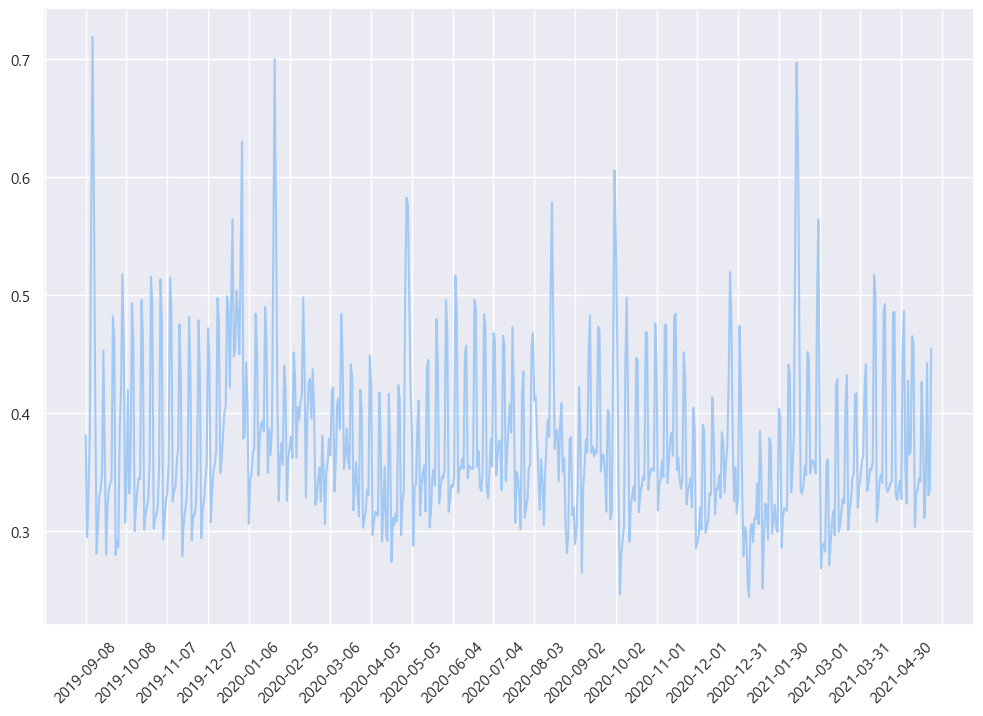

In [6]:
# 시계열도(Time series plot)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.plot(df_op_ts['op_rate_0d_all_cars'])
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=30.0)
ax.xaxis.set_major_locator(loc)
plt.show()

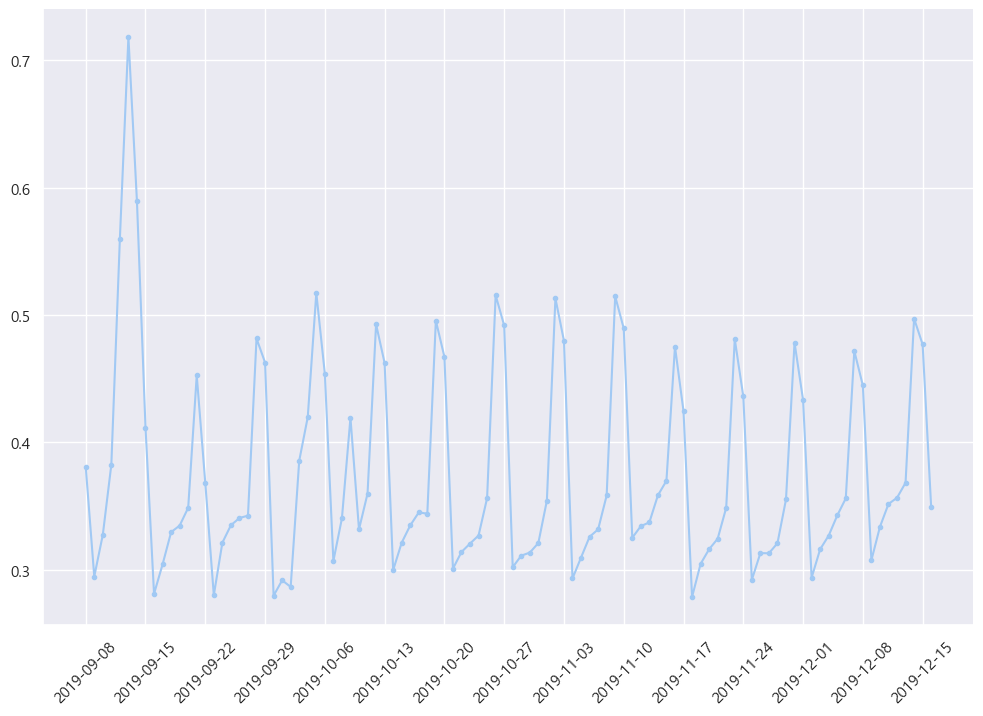

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.plot(df_op_ts['op_rate_0d_all_cars'][0:100], "b.-")
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0)
ax.xaxis.set_major_locator(loc)
plt.show()

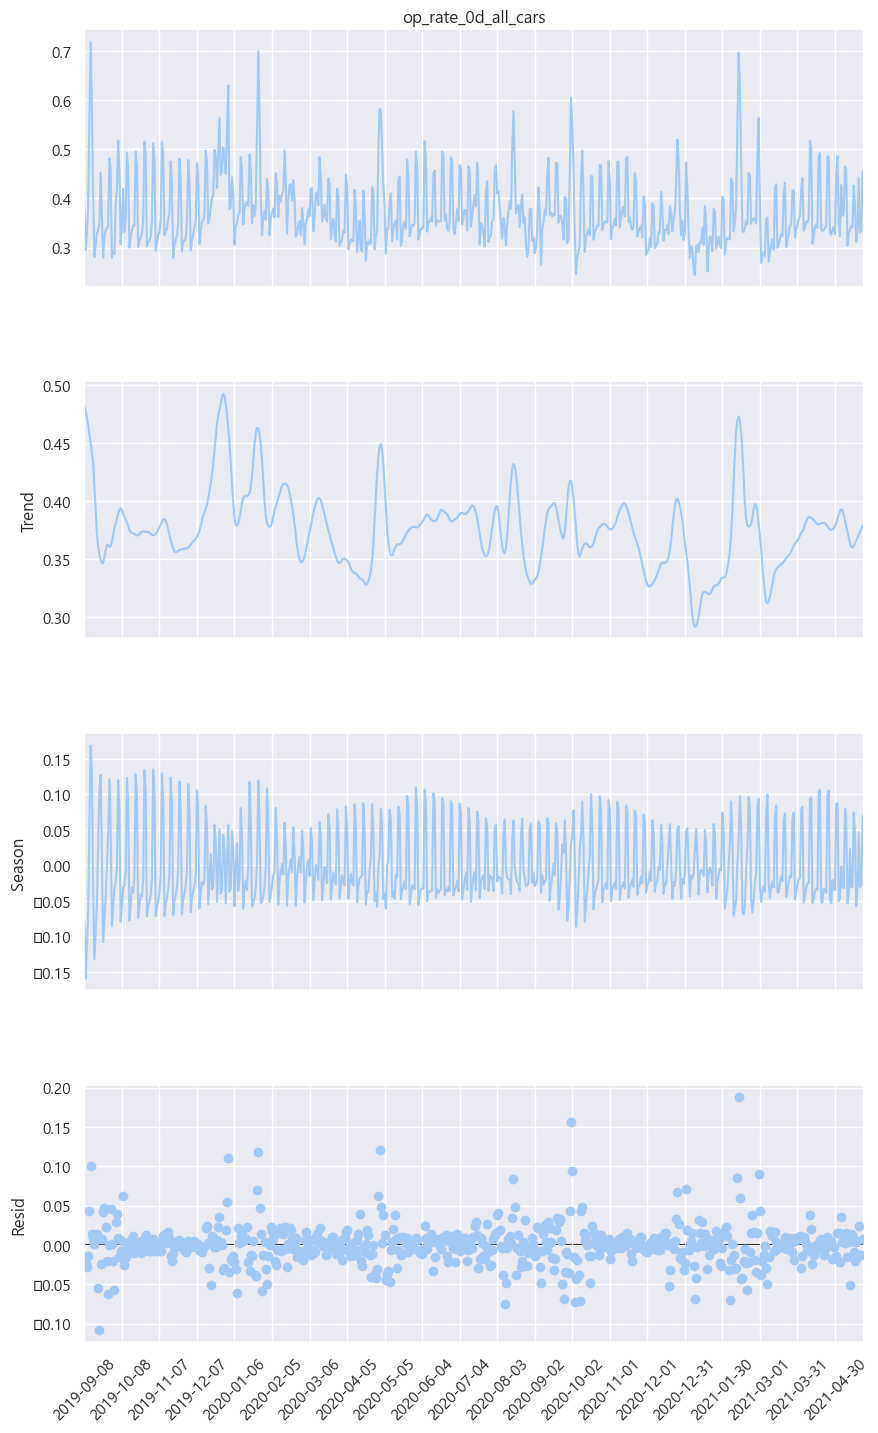

target_dates
2019-09-13    0.100568
2020-01-01    0.110451
2020-01-25    0.117945
2020-05-01    0.120080
2020-10-01    0.156595
2021-02-12    0.187517
Name: resid, dtype: float64


In [8]:
time_series_op_rate = df_op_ts['op_rate_0d_all_cars'] # Create univariate time series
STL_decomposed = STL(time_series_op_rate, seasonal=7, period=7).fit()
fig = STL_decomposed.plot()
fig.set_size_inches(10, 16)

for ax in fig.axes :
    loc = plticker.MultipleLocator(base=30.0)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(loc)
    ax.tick_params(axis='x', labelrotation=45)

plt.show()
print(STL_decomposed.resid[STL_decomposed.resid>0.1]) # 가설 검증

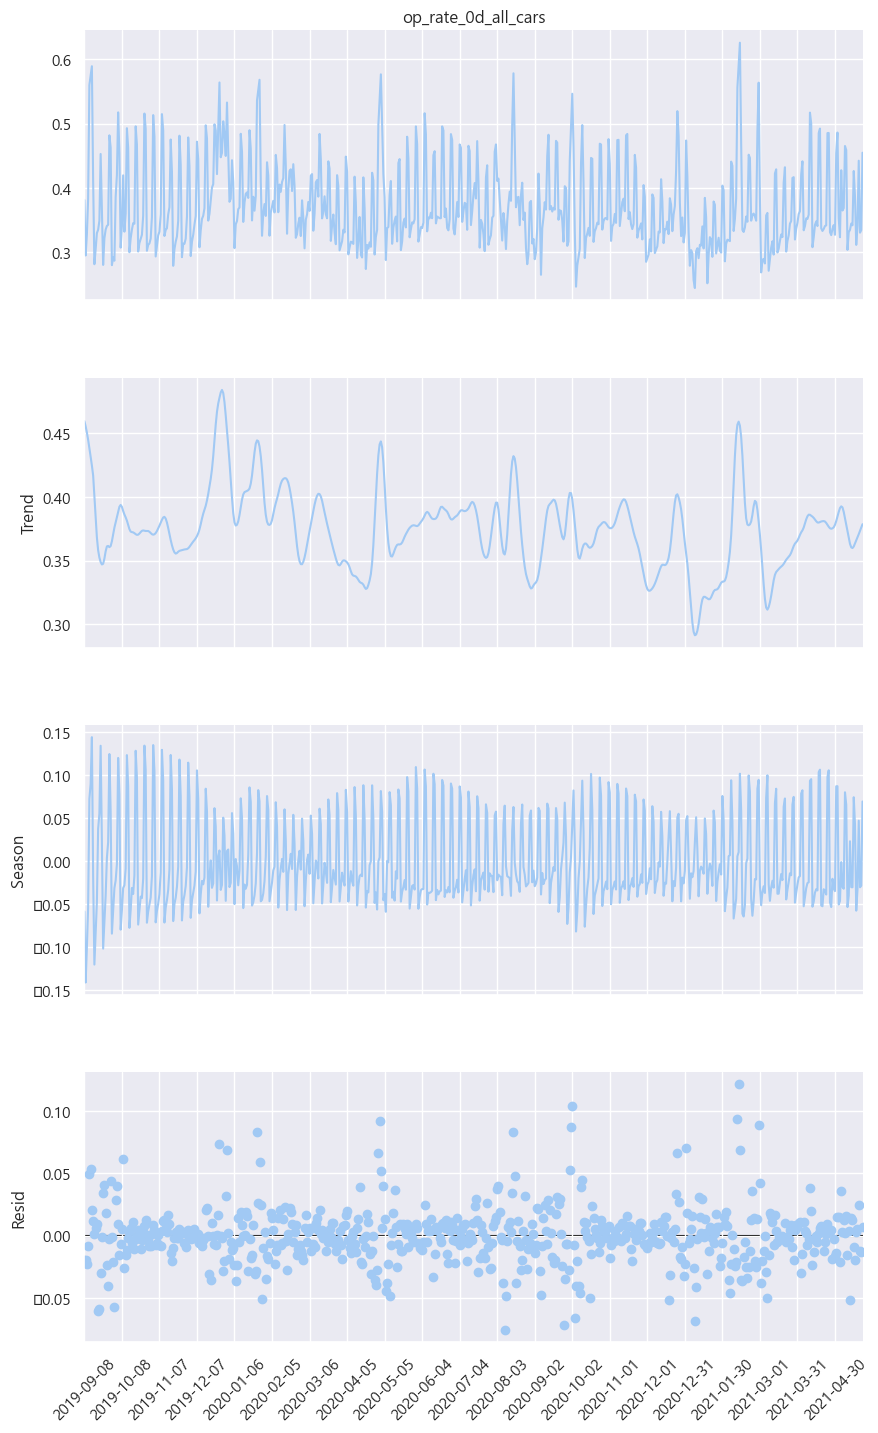

target_dates
2020-10-02    0.103744
2021-02-12    0.121464
Name: resid, dtype: float64


In [9]:
time_series_op_rate_replace = time_series_op_rate.copy()
time_series_op_rate_replace[STL_decomposed.resid>0.1] = np.NaN
time_series_op_rate_replace = time_series_op_rate_replace.interpolate(method='linear') # Linear interpolation

# Outlier를 처리한 뒤의 STL Decomposition
STL_decomposed_replace = STL(time_series_op_rate_replace, seasonal=7, period=7).fit()
fig = STL_decomposed_replace.plot()
fig.set_size_inches(10, 16)

for ax in fig.axes :
    loc = plticker.MultipleLocator(base=30.0)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(loc)
    ax.tick_params(axis='x', labelrotation=45)

plt.show()
print(STL_decomposed_replace.resid[STL_decomposed_replace.resid>0.1])

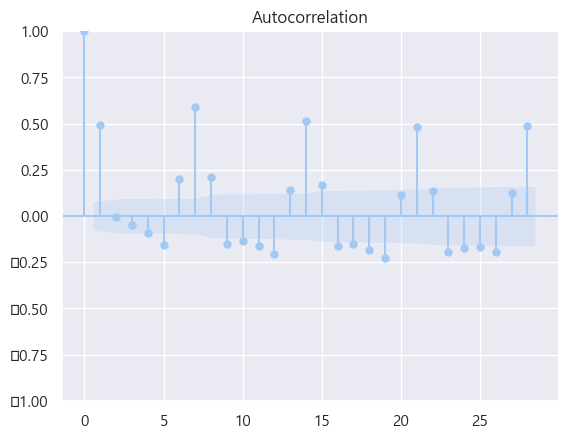

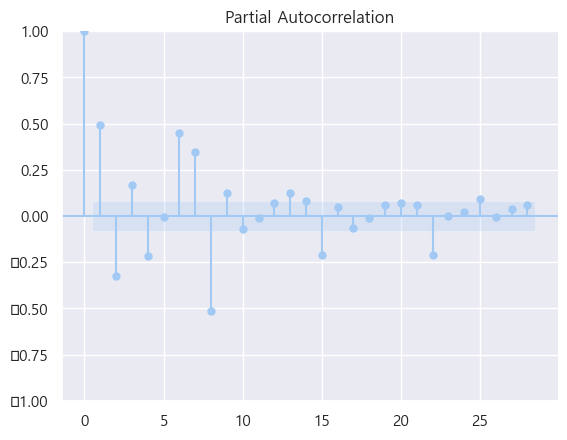

In [10]:
# ACF, PACF plot
plot_acf(time_series_op_rate_replace)
plot_pacf(time_series_op_rate_replace)
plt.show()

계절성이 보이기 때문에 주기7로 설정

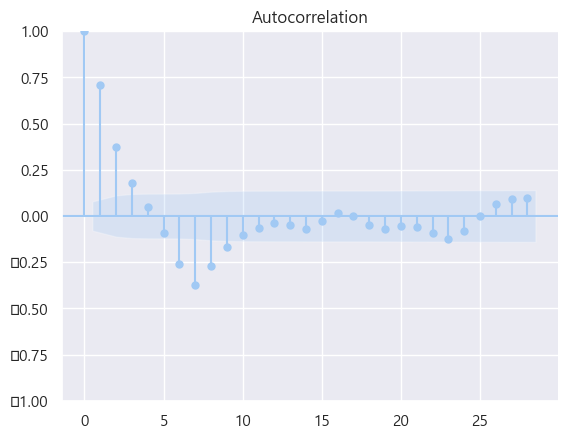

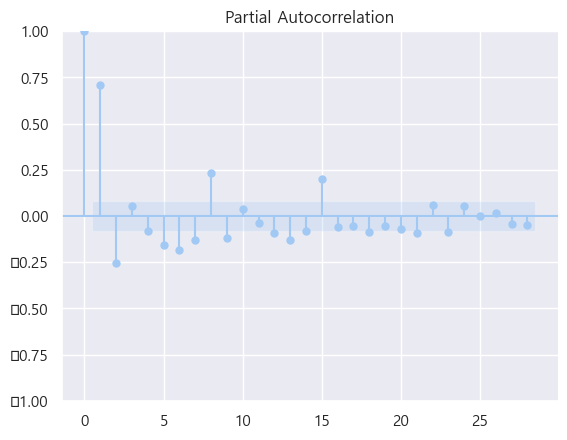

In [11]:
# 차분
time_series_op_rate_diff = time_series_op_rate_replace.diff(7).dropna()
plot_acf(time_series_op_rate_diff)
plot_pacf(time_series_op_rate_diff)
plt.show()

p-value of ADF test (diff 7): 1.537781597872036e-12


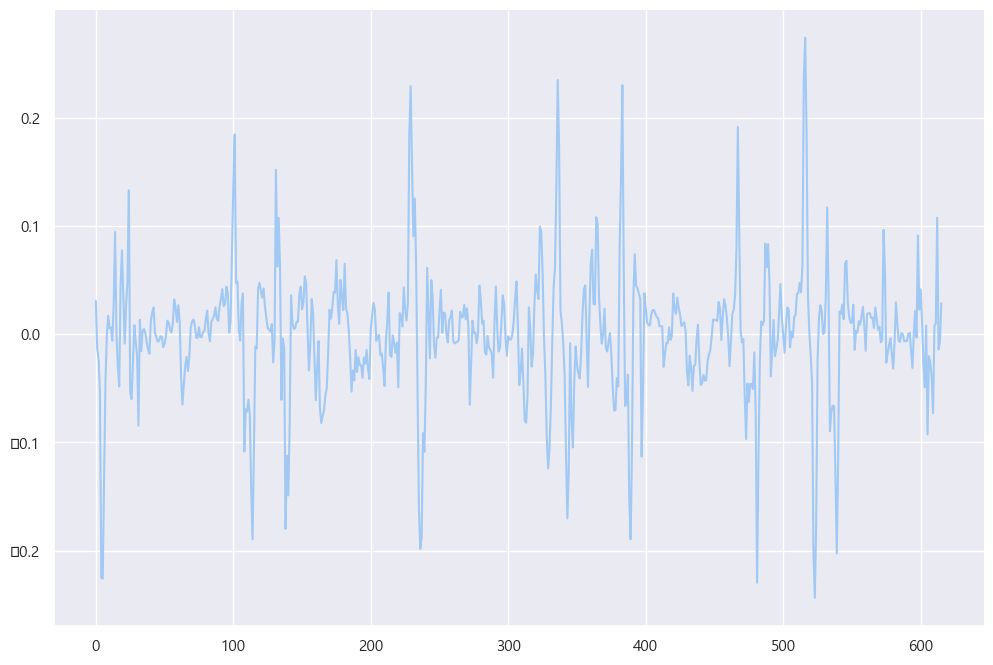

In [12]:
# ADF 검정
p_value = adfuller(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars)[1]
print(f'p-value of ADF test (diff 7): {p_value}')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars);

plt.show()

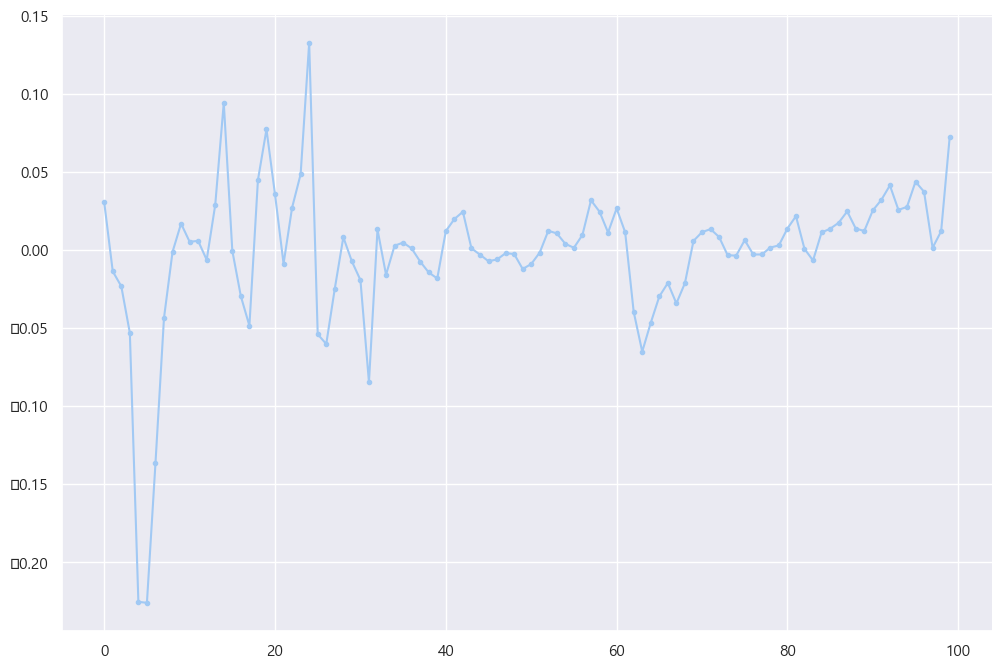

In [15]:
# 더 짧게 그려서 계절성이 제거되었는지 확인하기
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars[0:100], "b.-")

plt.show()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.
